In [10]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import collections as mc
plt.style.use('ggplot')

import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import pygraphviz

import json
import re
from pathlib import Path
from natsort import natsorted
from glob import glob
import numpy as np

def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


def read_graph(levels_dir):
    fns = natsorted(glob(f'{levels_dir}/*.txt'))
    level = len(fns)
    with open(fns[-1]) as f:
        g, i2k, label2i = edges2graph(f.readlines())
        for n in g.nodes:
            g.nodes[n]['level'] = level

        for e in g.edges:
            g.edges[e]['level'] = level

    for i,fn in enumerate(fns[:-1][::-1]):
        level -= 1
        with open(fn) as f:
            subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
            for n in subgraph.nodes:
                g.nodes[n]['level'] = level
            for e in subgraph.edges:
                g.edges[e]['level'] = level
    return g
    
    
    
def read_js(fn_in, center=True, scale=1):
    data_in = {}
    with open(fn_in) as f0:
        for line in f0:
            if line.startswith('//'):
                continue
            var_name, value = line.split(' = ')
            value = value.strip()
#             value = re.sub(r'(\d+):', r'"\1":', value)
            
            try:
                value = json.loads(value)
            except json.JSONDecodeError as e:
                print(e)
                print(repr(value[e.colno-5:e.colno+20]))
                return e
            data_in[var_name] = value

    print(data_in.keys())

    ## centralize data
    if center:
        cx = sum(data_in['crd_x'].values()) / len(data_in['crd_x'])
        cy = sum(data_in['crd_y'].values()) / len(data_in['crd_y'])
        for k in data_in['crd_x']:
            data_in['crd_x'][k] -= cx
            data_in['crd_y'][k] -= cy
    if scale is not None:
        for k in data_in['crd_x']:
            data_in['crd_x'][k] *= scale
            data_in['crd_y'][k] *= scale
            
    return data_in


def draw(g, pos, edges=True, labels=False, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    return ax


def update_coord(g, data):
    crd_x = data['crd_x']
    crd_y = data['crd_y']
    label_to_id = data.get('label_to_id', None)
    org_to_alphanum = data.get('org_to_alphanum', None)
    for n in g.nodes:
        node = g.nodes[n]
        full_label = node['label']
        if org_to_alphanum is None:
            short_label = full_label
        else:
            short_label = org_to_alphanum[full_label]
        
        node_id = str(label_to_id[short_label])
        
        x,y = crd_x[node_id], crd_y[node_id]
        node['pos'] = f'{x},{y}'
        node['weight'] = 0
    return g





In [11]:
## For BT's file format

def read_mtx(dir_in):
    fn_label = glob(f'{dir_in}/*.full.labels')[0]
    fn_coord = glob(f'{dir_in}/*.txt')[0]
    with open(fn_label) as fl, open(fn_coord) as fc:
        labels = [l.strip() for l in fl]
        coords = [[float(x) for x in l.split()[:2]] for l in fc]
    return dict(zip(labels, coords))
    
def update_coord_mtx(g, data):
    for n in tqdm(g.nodes):
        node = g.nodes[n]
        label = node['label']
        x,y = data[label.replace('"', '')]
        node['pos'] = f'{x},{y}'
        node['weight'] = 0
    return g

def centralize(data):
    c = np.array(list(data.values())).mean(0)
    for k in data:
        data[k] = (np.array(data[k]) - c).tolist()
    return data
    
def scale(data, s):
    for k in data:
        data[k] = (np.array(data[k]) * s).tolist()
    return data

## load txt graph file into networkx graph

dict_keys(['org_to_alphanum', 'alphanum_to_org', 'my_edges', 'label_to_id', 'id_to_label', 'nodes_to_levels', 'nodes_to_files', 'crd_x', 'crd_y'])
(0, {'id': 0, 'label': 'Annett Louisan', 'level': 8, 'pos': '5402.773930324565,-11381.619936598763', 'weight': 0})


<Axes: >

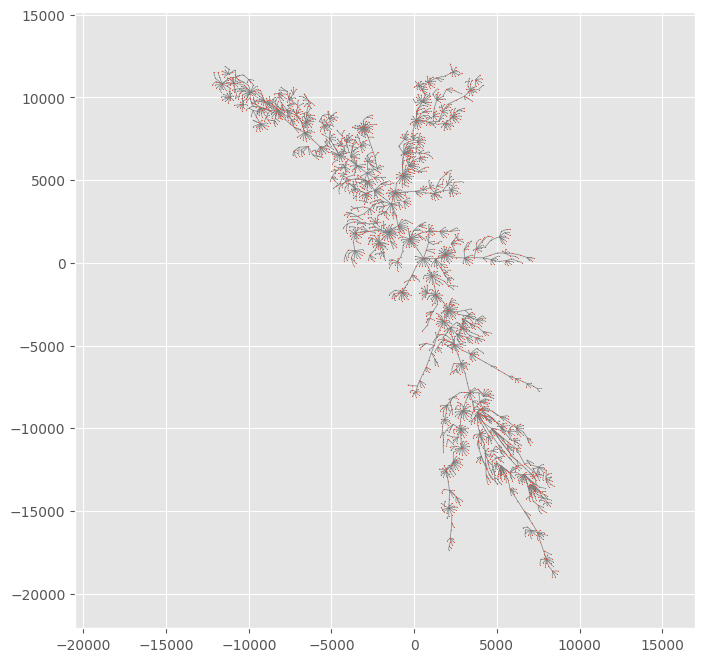

In [39]:
f = 'lastfm-DELG'
fn_in = './in/lastfm-DELG.json'
graph_dir = './in/txt/lastfm/'
scale = 1
g = read_graph(graph_dir)
data_in = read_js(fn_in, scale=scale)
G = update_coord(g, data_in)

# f = 'topics-DELG'
# fn_in = './in/topics-DELG.json'
# graph_dir = '../../zmlt/data/txt/topics_faryad_8level/'
# scale = 1
# g = read_graph(graph_dir)
# data_in = read_js(fn_in, scale=scale)
# G = update_coord(g, data_in)


# f = 'tol-DELG'
# fn_in = './in/tol-DELG.json'
# graph_dir = '../../zmlt/data/txt/tol_graphs_8level/'
# scale = 1

# f = 'topics-CG'
# fn_in = './in/topics-CG.json'
# graph_dir = '../../zmlt/data/txt/topics_faryad_8level/'
# scale = 200

# f = 'lastfm-CG'
# fn_in = './in/lastfm-CG.json'
# graph_dir = '../../zmlt/data/txt/lastfm/'
# scale = 200

# f = 'topicslarge-BT'
# fn_in = './in/topicslarge-BT.json'
# graph_dir = '../../zmlt/data/txt/topics_large/'
# scale = 10

# f = 'tol-CG'
# scale = 200
# graph_dir = '../../zmlt/data/txt/tol_graphs_8level/'
# g = read_graph(graph_dir)
# fn_in = './in/tol-CG.json'
# data_in = read_js(fn_in, scale=scale)
# G = update_coord(g, data_in)



# f = 'lastfm-BT'
# graph_dir = '../../zmlt/data/txt/lastfm/'
# coord_dir = './in/BT/lastfm/'
# g = read_graph(graph_dir)
# data_in = read_mtx(coord_dir)
# data_in = scale(centralize(data_in), 10)
# G = update_coord_mtx(g, data_in)

# f = 'topics-BT'
# graph_dir = '../../zmlt/data/txt/topics_faryad_8level/'
# coord_dir = './in/BT/topics/'
# g = read_graph(graph_dir)
# data_in = read_mtx(coord_dir)
# data_in = scale(centralize(data_in), 10)
# G = update_coord_mtx(g, data_in)

# f = 'tol-BT'
# graph_dir = '../../zmlt/data/txt/tol_graphs_8level/'
# coord_dir = './in/BT/tol/'
# g = read_graph(graph_dir)
# data_in = read_mtx(coord_dir)
# data_in = scale(centralize(data_in), 20)
# G = update_coord_mtx(g, data_in)

# f = 'mathlarge-BT'
# graph_dir = '../../zmlt/data/txt/math_genealogy_42/'
# coord_dir = './in/BT/mathlarge/'
# g = read_graph(graph_dir)
# data_in = read_mtx(coord_dir)
# data_in = scale(centralize(data_in), 20)
# G = update_coord_mtx(g, data_in)


for n in G.nodes(data=True):
    print(n)
    break
    
pos = {n:[float(x) for x in G.nodes[n]['pos'].split(',')] for n in G.nodes}
draw(G, pos, s=0.1)

## Generate layered maps (layers/*.dot and map.svg) from tree layout

In [33]:
# this is going to be the output directory
f

'lastfm-DELG'

In [14]:
!mkdir -p {f}/layers

In [34]:
## write sub trees in the hierarchy
levels = sorted(set([ G.nodes[i]['level'] for i in G.nodes]))
for l in tqdm(levels):
    n = [i for i in G.nodes if G.nodes[i]['level'] <= l]
    sub = G.subgraph(n)
    write_dot(sub, f'{f}/layers/graph-{l}.dot')

  0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
## read the original underlying graph (not just trees)

import pygraphviz as pgv
if 'topics' in f and 'large' not in f:
    fn_graph = '../data/datasets/topics/orginal/Topics_Graph_Connected.dot'
    original = nx.Graph(pgv.AGraph(fn_graph))
        
elif 'lastfm' in f:
    fn_graph = '../data/datasets/lastfm/dot/lastfmw_original.dot'
    original = nx.Graph(pgv.AGraph(fn_graph))
    for n in original.nodes:
        original.nodes[n]['label'] = original.nodes[n]['label'].replace('\\n', ' ')
            
elif 'topicslarge' in f:
    ## TODO load original graph instead of trees
    original = G
elif 'mathlarge' in f:
    ## TODO load original graph instead of trees
    original = G   
elif 'tol' in f:
    original = G    


In [ ]:
# query = 'inversion'

# for s,t in original.edges:
#     l1, l2 = original.nodes[s]['label'], original.nodes[t]['label']
#     if query in l1 or query in l2:
#         print(l1,'----', l2)

In [35]:
# Add the underlying graph edges to existing tree layout

o2label = {o:original.nodes[o]['label'] for o in original.nodes}
label2id = {G.nodes[i]['label']:i for i in G.nodes}
# print(set(o2label.values()) - set(label2id.keys()))
# print(set(label2id.keys()) - set(o2label.values()))
o2id = {o: label2id[o2label[o]] for o in original.nodes if o2label[o] in label2id}
# o2id

G0 = G.copy()
for n0,n1 in original.edges:
    if n0 in o2id and n1 in o2id:
        n0,n1 = o2id[n0], o2id[n1]
        if (n0,n1) not in G.edges:
            G0.add_edge(n0, n1)

In [20]:
write_dot(G0, "graph.dot")
write_dot(G, "tree.dot")

print(f)
!./mapgenerator.sh tree.dot
!mv out2 out3 map.svg graph.dot tree.dot {f}/

lastfm-DELG


In [26]:
# from IPython.display import SVG, display
# SVG(filename = f'{f}/map.svg')

## convert map file (.svg) and layers (layers/*.dot) to Geojson

In [32]:
dir_in = f'./{f}'
dir_out = f'../visualization_system/geojson/{f}'
print('[dir_in]', dir_in)
print('[dir_out]', dir_out)
if not Path(dir_out).exists():
    !mkdir -p {dir_out}
else:
    print(f'[warning] {dir_out} exists. The next cell may overwrite files there')
    


[dir_in] ./lastfm-DELG
[dir_out] ../visualization_system/geojson/lastfm-DELG
[warning] ../visualization_system/geojson/lastfm-DELG exists. The next cell may overwrite files there


In [22]:
%%time
!python ../geojson_generator/svg_to_geojson-mw.py {dir_in} {dir_out}

['./lastfm-DELG/layers/graph-1.dot', './lastfm-DELG/layers/graph-2.dot', './lastfm-DELG/layers/graph-3.dot', './lastfm-DELG/layers/graph-4.dot', './lastfm-DELG/layers/graph-5.dot', './lastfm-DELG/layers/graph-6.dot', './lastfm-DELG/layers/graph-7.dot', './lastfm-DELG/layers/graph-8.dot', './lastfm-DELG/layers/graph-9.dot', './lastfm-DELG/layers/graph-10.dot', './lastfm-DELG/layers/graph-11.dot', './lastfm-DELG/layers/graph-12.dot', './lastfm-DELG/layers/graph-13.dot', './lastfm-DELG/layers/graph-14.dot', './lastfm-DELG/layers/graph-15.dot', './lastfm-DELG/layers/graph-16.dot', './lastfm-DELG/layers/graph-17.dot']
graph edges: 19373
levels: 17
polygons: 75 polylines: 0 nodes: 2588
CPU times: user 127 ms, sys: 11.9 ms, total: 139 ms
Wall time: 13.5 s
